## The Problem

I have to organize a party for my friends. The problem is that many of my friends do not like each other. Hence I decided to organize the party in two locations. Any of my friends can join either of the parties. But my goal is to minimize the potential conflicts among my friends. A conflict will happen if two of my friends who doesn't like each other joins the same party.

<br>
<br>

## The Genotype

My friends joining one party or the other can be expressed in the following way,

<br>

```
 Bob  Jim   Robin  Anna
[-1,   1,   -1,     1]
```

<br>

1 means they joined party A and -1 means they joined party B.

<br>
<br>

### The weight matrix

We can find the relationships among my friends like below,

<br>

```
        Bob    Jim    Robin    Anna

Bob      0      1       -1       1

Jim      1      0        1      -1

Robin   -1     -1        0       1

Anna     1      1       -1       1
```

<br>

Any of my friend can't like or dislike themselves. An 1 in the weight matrix means that the corresponding friends like each other. A -1 means they don't.

<br>
<br>

### The Fitness Function

We can define the fitness function like below,

<br>
$$ F = \sum\limits_{i=1}^N \sum\limits_{j=1}^N W_{ij}G_{i}G_{j} $$
<br>

We need to write a genetic algorithm to find a combination which minimizes the collision and maximizes the fitness.

One goal is to see how the convergence is affected by crossover.

In [234]:
import numpy as np

In [224]:
# Hyperparameters

POPULATION_SIZE = 100
N_GENES = 50
N_GENERATIONS = 10000
CROSSOVER_RATE = 0.6
MUTATION_RATE = 1 / N_GENES

In [225]:
# Function to generate random weights

def get_weights(n):
    weights = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i != j:
                weights[i][j] = np.random.choice([-1, 1])

    return weights

In [226]:
# Generate random population and random weights

population = np.random.choice([1, -1], size=(POPULATION_SIZE, N_GENES))
w = get_weights(N_GENES)

In [227]:
# Genetic Algorithm Class

class MicrobialEvolutionGA:
    def __init__(self, population, weights, n_generations, n_genes, crossover_rate, mutation_rate, should_crossover):
        # Setup constructor parameters
        # Copy the passed population, so we can reuse it
        self.population = np.array(population)
        self.pop_size = len(population)
        self.weights = weights
        self.n_generations = n_generations
        self.n_genes = n_genes
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.should_crossover = should_crossover

        # Calculate our population fitness
        self.pop_fitness = self.get_population_fitness()

        self.wheel = None
        self.max_wheel = None

        # Init the roulette wheel
        self.init_wheel()

    # Method to initialize the roulette wheel parameters
    def init_wheel(self):
        self.wheel = np.cumsum(range(self.pop_size))
        self.max_wheel = self.wheel[-1]

    # Method to calculate fitness
    def get_fitness(self, ind):
        return sum(
            [sum([self.weights[i][j] * ind[i] * ind[j] for j in range(self.n_genes)]) for i in range(self.n_genes)]
        )

    # Method to calculate fitness for the whole population
    def get_population_fitness(self):
        return np.array([self.get_fitness(ind) for ind in self.population])

    # Select candidates by roulette wheel selection and return their indices in the population
    def select(self, ranked_fitness_indices):
        pick_1 = np.random.rand() * self.max_wheel
        ind_1 = 0
        while pick_1 > self.wheel[ind_1]:
            ind_1 += 1

        pick_2 = np.random.rand() * self.max_wheel
        ind_2 = 0
        while pick_2 > self.wheel[ind_2]:
            ind_2 += 1

        return ranked_fitness_indices[ind_1], ranked_fitness_indices[ind_2]

    # Run tournament among two individuals
    def tournament(self, idx1, idx2):
        fitness_1 = self.get_fitness(self.population[idx1])
        fitness_2 = self.get_fitness(self.population[idx2])
        return (idx1, idx2) if fitness_1 > fitness_2 else (idx2, idx1)

    # Perform crossover between the individuals. Copy winner genes to the loser and return the loser.
    def crossover(self, winner, loser):
        cross_indices = np.array([np.random.rand() < self.crossover_rate for _ in range(self.n_genes)])
        loser[cross_indices] = winner[cross_indices]
        return loser

    # Mutate an individual at a rate of `mutation_rate`, passed as constructor parameter
    def mutate(self, ind):
        mutation_indices = np.array([np.random.rand() < self.mutation_rate for _ in range(self.n_genes)])
        ind[mutation_indices] = ind[mutation_indices] * -1
        return ind

    # Run the evolution algorithm
    def evolution(self):

        # Keep track of the maximum fitness values over generations
        max_fitness_over_time = np.zeros(self.n_generations)

        # Run generations
        for gen in range(self.n_generations):
            # Sort the fitness values and get the sorted indices
            ranked_fitness_indices = np.argsort(self.pop_fitness)
            # Select two individuals according to roulette wheel selection process
            idx_1, idx_2 = self.select(ranked_fitness_indices)
            # Run tournament among the individuals, compute the winner and the loser indices.
            winner_idx, loser_idx = self.tournament(idx_1, idx_2)
            # Get the winner and loser individuals
            winner, loser = self.population[winner_idx], self.population[loser_idx]

            offspring = loser
            # Should we do crossover, according to our passed option?
            if self.should_crossover:
                # Do the crossover, copy winner genes into the loser, to produce offspring
                offspring = self.crossover(winner, loser)
            # Mutate the offspring in random slots
            offspring = self.mutate(offspring)

            # Calculate new fitness of the offspring individual
            new_fitness = self.get_fitness(offspring)
            # Copy the offspring's fitness value in the pop_fitness series.
            self.pop_fitness[loser_idx] = new_fitness
            # Store the maximum fitness of this generation into the max_fitness_over_time array.
            max_fitness_over_time[gen] = np.max(self.pop_fitness)

        # Return the maximum fitness values among generations
        return max_fitness_over_time

    # Get the best solution found so far.
    def best_solution_so_far(self):
        max_fitness = np.argmax(self.pop_fitness)
        return self.population[max_fitness]

    # Get the maximum fitness found so far.
    def max_fitness_so_far(self):
        return np.max(self.pop_fitness)

### Let's run our genetic algorithm with crossover.

In [228]:
np.random.seed(42)

ga_with_crossover = MicrobialEvolutionGA(population, w, N_GENERATIONS, N_GENES, CROSSOVER_RATE, MUTATION_RATE, True)
fitness_over_time_with_crossover = ga_with_crossover.evolution()
ga_with_crossover.max_fitness_so_far(), ga_with_crossover.best_solution_so_far()

(362.0,
 array([-1, -1, -1, -1,  1, -1, -1,  1,  1,  1, -1, -1,  1, -1,  1,  1,  1,
        -1, -1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1, -1,  1,  1, -1,  1,
        -1, -1, -1, -1, -1,  1, -1,  1,  1, -1,  1, -1,  1, -1, -1, -1]))

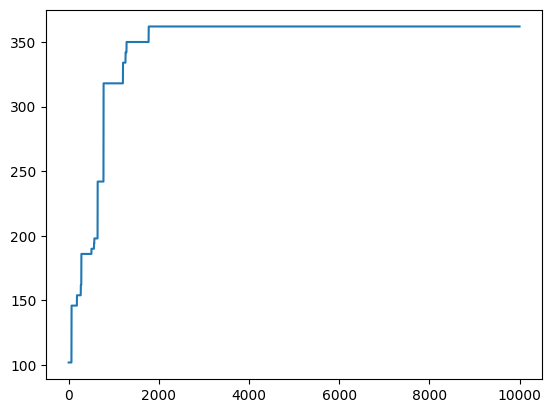

In [229]:
import matplotlib.pyplot as plt

plt.plot(fitness_over_time_with_crossover)

It is clear from above that the GA with crossover converged immediately after 2000 generations. Then it remained stable in the converged value.

### Now let's run it without crossover.

In [230]:
np.random.seed(42)

ga_without_crossover = MicrobialEvolutionGA(population, w, 40_000, N_GENES, CROSSOVER_RATE, MUTATION_RATE, False)
fitness_over_time_without_crossover = ga_without_crossover.evolution()
ga_without_crossover.max_fitness_so_far(), ga_without_crossover.best_solution_so_far()

(186.0,
 array([-1, -1,  1,  1,  1, -1, -1,  1, -1,  1,  1, -1,  1, -1, -1,  1, -1,
        -1,  1, -1,  1,  1, -1,  1, -1, -1,  1, -1, -1, -1,  1,  1,  1, -1,
         1,  1, -1,  1, -1, -1, -1,  1,  1, -1, -1,  1,  1,  1, -1,  1]))

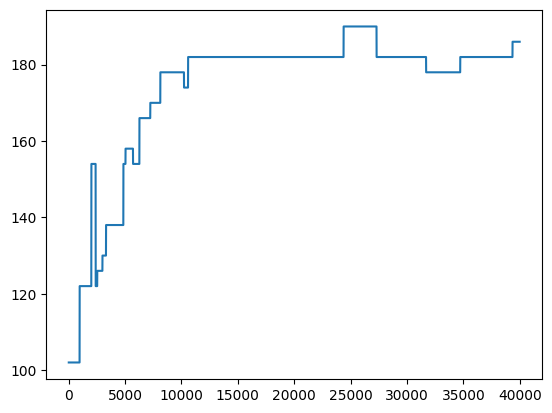

In [231]:
import matplotlib.pyplot as plt

plt.plot(fitness_over_time_without_crossover)

On the other hand the GA without crossover didn't converge even after 40000 generations. Also it's not steady. It went down several times, but kept an upward trend in general.